In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image as PILImage
from IPython.display import display, Image as IPImage
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import keras.applications.xception as xception

# Function to extract image name without extension
def extract_image_name(filename):
    return os.path.splitext(filename)[0]

def generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, img_size=(299, 299), alpha=0.4, cam_path="save_cam_image.jpg", original_name=None):
    # Load image
    def get_img_array(img_path, size):
        img = load_img(img_path, target_size=size)
        array = img_to_array(img)
        array = np.expand_dims(array, axis=0)
        return array

    # Generate Grad-CAM heatmap
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])  #預測結果中的最高機率類別
            class_channel = preds[:, pred_index] 

        grads = tape.gradient(class_channel, last_conv_layer_output) #每個像素在該類別中的重要性
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]

        #生成特徵圖
        cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
        cam = tf.nn.relu(cam)

        heatmap = cam / tf.reduce_max(cam)
        return heatmap.numpy()

    # Save and display Grad-CAM:存取在code所位於的目錄
    def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
        img = load_img(img_path)
        img = img_to_array(img)

        heatmap = np.uint8(255 * heatmap)

        jet = mpl.cm.get_cmap("jet")

        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = img_to_array(jet_heatmap)

        Superimposed_img = jet_heatmap * alpha + img
        Superimposed_img = array_to_img(Superimposed_img)

        Superimposed_img.save(cam_path)
        display(IPImage(cam_path))

  
    #各函式依順序執行
    # Preprocess and prepare the image
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Make model with imagenet dataset
    model = model_builder(weights="imagenet")
    model.layers[-1].activation = None

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Save and display Grad-CAM
    save_and_display_gradcam(img_path, heatmap, cam_path=cam_path, alpha=alpha)


執行大函式中包的三小函式

C:\Users\BOIL\AppData\Local\Temp\ipykernel_24296\3654747017.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap("jet")


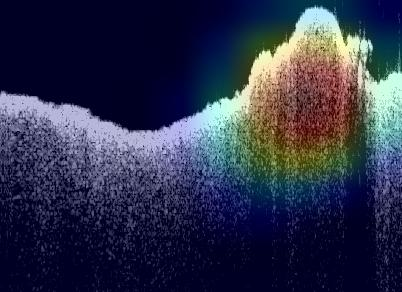

In [ ]:
output_png_path = r'\\BOIL-NAS\home\Dental OCT\tooth_data_png\201903220033.png'

# Call the function with required parameters
generate_and_display_gradcam(
    img_path=output_png_path,
    model_builder=xception.Xception,
    last_conv_layer_name="block14_sepconv2_act",
    preprocess_input=xception.preprocess_input,
    decode_predictions=xception.decode_predictions,
    img_size=(299, 299),
    alpha=0.4,
    cam_path="save_cam_image.jpg"
)

把整個folder的file都用gradCAM處理過

利用OCT影像中的灰度值变化来检测和区分正常和异常的牙结石 ->

使用Canny进行边缘检测：生成边缘图像。
计算边缘的平滑度：通过计算边缘图像中的梯度变化或连通组件的形状特征来评估平滑度。
设定阈值进行分类：根据平滑度指标将图像分类为牙结石或正常影像。

測試threshold_multiotsu(有進展)

成功圈選出grayscale輪廓

In [3]:
import sys
sys.path.append(r"D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\reqiured_funcs") #存取所需函式的路徑


In [ ]:
from del_files import delete_files_in_directory

output_dir = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\dental_calculus_profile'

# # 刪除檔案
delete_files_in_directory(output_dir)


In [9]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_multiotsu
import math

# 定義圖像的路徑列表
image_paths = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\NOR_png'

# 指定輸出目錄
output_dir = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\NOR_png\dental_calculus_profile'
os.makedirs(output_dir,exist_ok=True)

# listdir把folder也算進去了! 建立條件式，把folder排除，才可妥善處理圖檔
for filename in os.listdir(image_paths):
    # 組合完整的圖像路徑
    image_path = os.path.join(image_paths, filename)

    #要在圖檔的情況下進行draw_contour! 所以要注意縮排
    # 檢查是否是檔案以及檔案是否是圖像檔案
    if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # 讀取圖像
        image = cv2.imread(image_path)
        if image is None:   #內含兩個folder-> continue
            print(f"無法讀取圖像：{image_path}")
            continue 
#輪廓是基於影像亮度值(灰度值)來繪製的
        # 检查图像是否已经是灰度图像
        if len(image.shape) == 3:  # 如果图像有三个通道
            # 将图像转换为灰度
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            # 图像已经是灰度图像
            gray = image



        # 应用 Multi-Otsu 阈值分割
        thresholds = threshold_multiotsu(gray, classes=2)

        # 根据阈值将图像分割成多个区域
        regions = np.digitize(gray, bins=thresholds)

        # raw
        # 创建一个新的图像来显示平滑和不平滑部分
        smooth = np.zeros_like(gray)

        # 假设中间的区域是平滑的
        smooth[regions == 1] = 255

        # # 找到平滑部分的轮廓: 逆時針尋找
        contours, _ = cv2.findContours(smooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        #可以選擇cv2.RETR_TREE和cv2.CHAIN_APPROX_NONE得到不同檢測結果

        # 計算輪廓
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = 1e-7 * cv2.arcLength(largest_contour, True)  #epsilon 調小，會更接近原始輪廓
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        # 繪製輪廓 : 調整range(len(approx)-1) 範圍
        for i in range(len(approx)-1):
        # for i in range(0,3):
            cv2.line(image, tuple(approx[i][0]), tuple(approx[i + 1][0]), (0, 255, 0), 2)
        # 連接最後一個點和第一個點，形成封閉的多邊形
        cv2.line(image, tuple(approx[-1][0]), tuple(approx[0][0]), (0, 255, 0), 2)

        # 获取原始圖像的文件名
        image_name = os.path.basename(image_path)
        # 構建保存的檔案路徑
        save_path = os.path.join(output_dir, image_name)
        
        # 保存處理後的圖像
        cv2.imwrite(save_path, image)


In [7]:
import os
import cv2
import numpy as np
from skimage.filters import threshold_multiotsu
import math

# 定義圖像的路徑列表
image_paths = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png'

# 指定輸出目錄
output_dir = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\dental_calculus_profile'

# listdir把folder也算進去了! 建立條件式，把folder排除，才可妥善處理圖檔
for filename in os.listdir(image_paths):
    # 組合完整的圖像路徑
    image_path = os.path.join(image_paths, filename)

    #要在圖檔的情況下進行draw_contour! 所以要注意縮排
    # 檢查是否是檔案以及檔案是否是圖像檔案
    if os.path.isfile(image_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # 讀取圖像
        image = cv2.imread(image_path)
        if image is None:   #內含兩個folder-> continue
            print(f"無法讀取圖像：{image_path}")
            continue 

        # 检查图像是否已经是灰度图像
        if len(image.shape) == 3:  # 如果图像有三个通道
            # 将图像转换为灰度
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            # 图像已经是灰度图像
            gray = image



        # 应用 Multi-Otsu 阈值分割
        thresholds = threshold_multiotsu(gray, classes=2)

        # 根据阈值将图像分割成多个区域
        regions = np.digitize(gray, bins=thresholds)

        # raw
        # 创建一个新的图像来显示平滑和不平滑部分
        smooth = np.zeros_like(gray)

        # 假设中间的区域是平滑的
        smooth[regions == 1] = 255

        # # 找到平滑部分的轮廓: 逆時針尋找
        contours, _ = cv2.findContours(smooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 計算輪廓
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = 1e-7 * cv2.arcLength(largest_contour, True)  #epsilon 調小，會更接近原始輪廓
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        # 繪製輪廓 : 調整range(len(approx)-1) 範圍
        for i in range(len(approx)-1):
        # for i in range(0,3):
            cv2.line(image, tuple(approx[i][0]), tuple(approx[i + 1][0]), (0, 255, 0), 2)
        # 連接最後一個點和第一個點，形成封閉的多邊形
        cv2.line(image, tuple(approx[-1][0]), tuple(approx[0][0]), (0, 255, 0), 2)

        # 获取原始圖像的文件名
        image_name = os.path.basename(image_path)
        # 構建保存的檔案路徑
        save_path = os.path.join(output_dir, image_name)
        
        # 保存處理後的圖像
        cv2.imwrite(save_path, image)


In [14]:
import cv2
import numpy as np
from skimage.filters import threshold_multiotsu
import math


# 定義圖像的路徑列表
image_paths = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png'
# image_paths = [
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra1_frame21.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra2_frame203.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra3_frame577.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra4_frame880.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra5_frame673.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra6_frame537.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra7_frame246.png',
#     r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\supra8_frame411.png'
# ]

#取出目標邊長，也就是最頂邊(牙齒輪廓)

# 遍歷圖像列表
for (j, image_path) in enumerate(image_paths):
    # 讀取圖像
    image = cv2.imread(image_path) 

        # 检查图像是否已经是灰度图像
    if len(image.shape) == 3:  # 如果图像有三个通道
        # 将图像转换为灰度
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # 图像已经是灰度图像
        gray = image

    # 应用 Multi-Otsu 阈值分割: 因此而影響drawContours結果? 沒錯! class設為2，標出灰色區 (>3只會更麻煩!)
    thresholds = threshold_multiotsu(gray, classes=2)

    # 根据阈值将图像分割成多个区域
    regions = np.digitize(gray, bins=thresholds)

    # raw
    # 创建一个新的图像来显示平滑和不平滑部分
    smooth = np.zeros_like(gray)

    # 假设中间的区域是平滑的
    smooth[regions == 1] = 255

    # # 找到平滑部分的轮廓: 逆時針尋找
    contours, _ = cv2.findContours(smooth, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 計算輪廓
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.003 * cv2.arcLength(largest_contour, True)  #epsilon 調小，會更接近原始輪廓
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    # 繪製輪廓 ，界定出最佳range，繪製出牙結石輪廓
    # for i in range(len(approx)//2,len(approx)):

    #越平滑的牙齒，在越小的range便可以一次繪製出整個輪廓
    # for i in range(5):
    for i in range(len(approx)-1):
        cv2.line(image, tuple(approx[i][0]), tuple(approx[i + 1][0]), (0, 255, 0), 2)
    # 連接最後一個點和第一個點，形成封閉的多邊形
    cv2.line(image, tuple(approx[-1][0]), tuple(approx[0][0]), (0, 255, 0), 2)

    
    # 保存處理後的圖像
    cv2.imwrite(f'contour_edges_supra{j}.png', image)


# 影像分割!!-> 把所需的邊裁切出來

        
    
    
#進而標示出多邊形的4個頂點




想測試可以丟入上述code完完

In [ ]:
# # 假设我们只针对最大的轮廓进行分析
# if contours:
#     largest_contour = max(contours, key=cv2.contourArea)
    
#     # 计算轮廓的边界框
#     x, y, w, h = cv2.boundingRect(largest_contour)

#     # 左上角坐标
#     top_left = (x, y)
#     # 右上角坐标
#     top_right = (x + w, y)
#     # 左下角坐标
#     bottom_left = (x, y + h)
#     # 右下角坐标
#     bottom_right = (x + w, y + h)

#     # 在图像上标记出角点(其中2點標示錯誤!) 1 : radius
#     cv2.circle(image, top_left, 1, (0, 255, 0), -1)  # 左上角
#     cv2.circle(image, top_right, 1, (0, 255, 0), -1)  # 右上角
#     cv2.circle(image, bottom_left, 1, (0, 255, 0), -1)  # 左下角
#     cv2.circle(image, bottom_right, 1, (0, 255, 0), -1)  # 右下角

#     # 保存图像到当前目录
#     cv2.imwrite('contour_corners.png', image)


# # # # 创建一个空白图像，用于绘制轮廓的差集(上下都有)
    # difference_contour_image = np.zeros_like(gray)

    # # 取平滑部分轮廓的差集
    # smooth_difference = cv2.subtract(smooth, difference_contour_image)
    
    # # 找到平滑部分的轮廓
    # contours, _ = cv2.findContours(smooth_difference, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # 将轮廓绘制到原始图像上
    # cv2.drawContours(image, contours, -1, (0, 0, 255), 2)  # 红色线条，厚度为2像素

    # # 保存图像到当前目录 (標錯區域!)
    # cv2.imwrite('contour_diff_image.png', image)

cv2.arcLength
cv2.contourArea
圓形度
傅里叶描述子(也許有用!)

每張OCT加gradCAM

In [ ]:
# import glob

# # Process all images in the specified directory
# imgs_path = glob.glob(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\*.png')
# model_builder = xception.Xception  # Replace with your model
# last_conv_layer_name = 'block14_sepconv2_act'  # Replace with the name of the last convolutional layer in your model
# preprocess_input = xception.preprocess_input
# decode_predictions = xception.decode_predictions

# #建存cam影像目錄
# cam_path = r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\CAM_outputs'
# os.makedirs(cam_path, exist_ok=True)


# # Loop through all image paths and generate Grad-CAM for each
# for img_path in imgs_path:
#     img_name = extract_image_name(os.path.basename(img_path))
#     cam_output_path = os.path.join(r'D:\OCT\dental OCT\bare tooth\ensemble_model_aug\code\2024_dentalCalculus\CAL_png\CAM_outputs', f'{img_name}_cam.jpg')
#     generate_and_display_gradcam(img_path, model_builder, last_conv_layer_name, preprocess_input, decode_predictions, cam_path=cam_output_path)

大函式解體，分別執行小函式(方便觀察)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image as IPImage, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

output_png_path = r'\\BOIL-NAS\home\Dental OCT\tooth_data_png\201903220033.png'



## The local path to our target image

#img_path= output_png_path
#img_path=r'C:\Users\BOIL\OneDrive\圖片\nancy_graph\初戀.png'

# 打开 TIFF 文件

#display(IPImage(img_path))  # 秀原圖
display(IPImage(output_png_path))


"""利用load_img載入圖像並用img_to_array轉成array，並擴展維度，跟pretrained好的Xception model互相匹配"""
def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    ## We add a dimension to transform our array into a "batch" : because model expect input_shape:(batch_size, height, width, channels)
    array = np.expand_dims(array, axis=0)
    return array

"""從輸入映射到輸出"""
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient : use global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific 
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]

    #原本算法
    # heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]  # GAP
    # heatmap = tf.squeeze(heatmap)

    # ## For visualization purpose
    # heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    #試看看別種計算grad方式，看是否能降噪
    # 计算CAM
    cam = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    cam = tf.nn.relu(cam)

    # 归一化CAM
    heatmap = cam / tf.reduce_max(cam)

    return heatmap.numpy()

In [ ]:
## Preparing the image
img_array = preprocess_input(get_img_array(output_png_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted of image:", decode_predictions(preds, top=1)[0])

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = load_img(img_path)
    img = img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)
   

    ## Displaying Grad CAM
    display(IPImage(cam_path))


save_and_display_gradcam(output_png_path, heatmap)

for loop處理整個folder的圖片，轉為grad-CAM(之前跑的影像會有失真，尚未解決)

In [ ]:
import os
output_png_path = r'\\BOIL-NAS\homes\311514061\Dental OCT\tooth_data_png'
save_cam_path=r'\\BOIL-NAS\homes\311514061\Dental OCT\tooth_data_cam'
os.makedirs(save_cam_path,exist_ok=True)



# Get a sorted list of filenames
sorted_filenames = sorted([filename for filename in os.listdir(output_png_path) if filename.endswith('.png')])  # 照順序輸出png檔
for filename in sorted_filenames:
    #print(filename)
    img_array = preprocess_input(get_img_array(output_png_path, size=img_size))


    preds = model.predict(img_array)
    
    ## Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(output_png_path, heatmap, cam_path=os.path.join(save_cam_path, filename))